In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.signal as ss

jax.config.update("jax_enable_x64", True)

import discovery.flow as dsf
from flowjax.flows import triangular_spline_flow
from flowjax.distributions import StandardNormal
from ripplegw.waveforms.IMRPhenomD import gen_IMRPhenomD_hphc

print("JAX devices:", jax.devices())

JAX devices: [CudaDevice(id=0)]


## Set up LIGO Data

In [2]:
# ==========================================
# STEP 1: Load data with windowing + PSD
# ==========================================
from scipy.signal.windows import tukey

data_raw = np.loadtxt("gw250114_20s.txt")
noise_raw = np.loadtxt("gw250114_50s_offsource.txt")

t, h = data_raw[:, 0], data_raw[:, 1]
t_noise, h_noise = noise_raw[:, 0], noise_raw[:, 1]
dt = float(t[1] - t[0])
fs = 1.0 / dt
fs_noise = 1/(float(t_noise[1] - t_noise[0]))

# Apply Tukey window to suppress spectral leakage from low-freq seismic noise
window = tukey(len(h), alpha=0.1)
h_win = h * window

f = jnp.fft.rfftfreq(len(h), d=dt)
d_f = jnp.fft.rfft(h_win) * dt   # windowed FFT
df = float(f[1] - f[0])

# PSD from off-source noise (welch handles its own windowing internally)
f_psd, psd_val = ss.welch(h_noise, fs=fs_noise, nperseg=int(fs_noise * 2))
psd = jnp.interp(f, f_psd, psd_val)

flow_freq, fhigh = 20.0, 512.0
mask = (f >= flow_freq) & (f <= fhigh)

# Sanity check: noise-only inner product should be ~2*T*BW = 2*20*492 ≈ 19680
d_d = 4.0 * jnp.real(jnp.sum(jnp.abs(d_f[mask])**2 / psd[mask]) * df)
print(f"dt={dt}, fs={fs}, df={df}")
print(f"Freq points: {len(f)}, in band: {mask.sum()}")
print(f"<d|d> = {d_d:.1f}  (expected ~19680 for noise-only)")
print(f"noise-only log-lik = {-0.5*d_d:.1f}")

dt=0.000244140625, fs=4096.0, df=0.05
Freq points: 40961, in band: 9841
<d|d> = 21160.8  (expected ~19680 for noise-only)
noise-only log-lik = -10580.4


## Sanity Check
Use ripplegw for the waveform generation because it returns an output differentiable in jax

In [3]:
# ==========================================
# STEP 2: Test waveform + likelihood with known-good params
# ==========================================
# ripplegw params: [Mc, eta, chi1, chi2, dist_mpc, tc, phic, iota]
test_params = jnp.array([30.0, 0.25, 0.0, 0.0, 400.0, 0.0, 0.0, 0.0])

f_nz = f[1:]
hp, hc = gen_IMRPhenomD_hphc(f_nz, test_params, flow_freq)

h_det = jnp.concatenate([jnp.array([0j]), hp])
h_det = jnp.where(f < flow_freq, 0j, h_det)
res = d_f[mask] - h_det[mask]
ll = -0.5 * 4.0 * jnp.real(jnp.sum(jnp.conj(res) * res / psd[mask]) * df)

print(f"hp max abs: {jnp.max(jnp.abs(hp)):.2e}")
print(f"Log-likelihood at test point: {ll:.2f}")
print(f"Log-lik ratio vs noise-only: {ll - (-0.5*d_d):.2f}")

hp max abs: 1.09e-19
Log-likelihood at test point: -13788.61
Log-lik ratio vs noise-only: -3208.22


## Define LIGO Model that can be used as direct input into flow
Since the discovery package is created for Pulsar Timing Array data, the Pulsar data classes are not applicable to LIGO data which contains strain, rather than correlations. However, we can still use the `discovery.flow` because it has been specified from the `Flowjax` built to do many things, among them variational inference.

Variational inference allows us to take LIGO strain data and a physical waveform model as input, use a normalizing flow model to learn the shape of the posterior distribution that best explains the data, and optimize this approximation through gradient-based training.

`discovery.flow` module has an elboLoss function which takes as input a target (parameters and ranges) and the number of samples (num params) which is used for the loss calculation. This loss is then fed as an input to the `dsf.variationalFit` trainer which the model uses to optimize the posterior distribution fit.  

In [4]:
# ==========================================
# STEP 3: Define model and target, test values + gradients
# ==========================================
class LIGOModel:
    def __init__(self):
        self.f, self.d_f, self.df = f, d_f, df
        self.psd, self.mask = psd, mask
        self.f_ref, self.f_min = flow_freq, flow_freq

    def get_waveform(self, params):
        f_nz = self.f[1:]
        hp, hc = gen_IMRPhenomD_hphc(f_nz, params, self.f_ref)
        h_det = jnp.concatenate([jnp.array([0j]), hp])
        h_det = jnp.where(self.f < self.f_min, 0j, h_det)
        # Replace NaN with 0 so bad parameter combos yield noise-only
        # likelihood (finite value + finite gradient) instead of poisoning
        # the entire batch gradient average
        h_det = jnp.nan_to_num(h_det, nan=0.0)
        return h_det

    def log_likelihood(self, params):
        h = self.get_waveform(params)
        res = self.d_f[self.mask] - h[self.mask]
        snr_sq = 4.0 * jnp.real(jnp.sum(jnp.conj(res) * res / self.psd[self.mask]) * self.df)
        return -0.5 * snr_sq


class FlowTarget:
    """Target distribution for the normalizing flow.

    Maps unconstrained z in R^8 to the 8 ripplegw IMRPhenomD parameters:
        [Mc, eta, chi1, chi2, dist, tc, phic, iota]
    via a tanh transform with specified bounds.
    """

    param_names = ['Mc', 'eta', 'chi1', 'chi2', 'dist', 'tc', 'phic', 'iota']

    def __init__(self, model):
        self.model = model
        self.dim = 8
        # Bounds in ripplegw order: [Mc, eta, chi1, chi2, dist, tc, phic, iota]
        # Tightened around GW250114 expected values for stable training
        self.a = jnp.array([25.0,  0.15, -0.5, -0.5, 100.0, -0.2,   0.0,  0.0])
        self.b = jnp.array([40.0,  0.25,  0.5,  0.5, 1000.0, 0.2, 2*jnp.pi, jnp.pi])

    def map_to_physical(self, z):
        """Map unconstrained z to bounded physical parameters via tanh."""
        return 0.5 * (self.b + self.a + (self.b - self.a) * jnp.tanh(z))

    def samples_to_physical(self, z_batch):
        """Batch version of map_to_physical for post-training analysis."""
        return jax.vmap(self.map_to_physical)(z_batch)

    def logprior(self, z):
        """Log-Jacobian of the tanh transform (uniform prior in physical space)."""
        return jnp.sum(jnp.log(2.0) - 2.0 * jnp.logaddexp(z, -z))

    def __call__(self, z):
        phys = self.map_to_physical(z)
        ll = self.model.log_likelihood(phys)
        ll = jnp.nan_to_num(ll, nan=-1e10, posinf=-1e10, neginf=-1e10)
        return ll + self.logprior(z)


model = LIGOModel()
target = FlowTarget(model)

# Test values and gradients
key = jax.random.key(0)
z_test = jax.random.normal(key, (5, target.dim))
grad_fn = jax.grad(target)

print("Target values and gradients on random z samples:")
for i in range(5):
    z = z_test[i]
    phys = target.map_to_physical(z)
    val = target(z)
    g = grad_fn(z)
    names = target.param_names
    param_str = ", ".join(f"{names[j]}={phys[j]:.3f}" for j in range(8))
    print(f"  {param_str}")
    print(f"    -> target={val:.2e}, max|grad|={jnp.max(jnp.abs(g)):.2e}, any_nan={bool(jnp.any(jnp.isnan(g)))}")


Target values and gradients on random z samples:
  Mc=30.978, eta=0.167, chi1=0.474, chi2=0.093, dist=586.311, tc=-0.071, phic=5.751, iota=2.083
    -> target=-1.11e+04, max|grad|=1.04e+03, any_nan=False
  Mc=33.135, eta=0.165, chi1=0.392, chi2=-0.458, dist=708.327, tc=0.197, phic=3.936, iota=1.137
    -> target=-1.09e+04, max|grad|=5.82e+02, any_nan=False
  Mc=28.837, eta=0.218, chi1=-0.097, chi2=0.453, dist=576.541, tc=0.028, phic=3.727, iota=1.644
    -> target=-1.09e+04, max|grad|=5.15e+02, any_nan=False
  Mc=25.838, eta=0.190, chi1=0.403, chi2=-0.489, dist=320.544, tc=0.059, phic=0.570, iota=1.591
    -> target=-1.15e+04, max|grad|=1.82e+03, any_nan=False
  Mc=38.923, eta=0.151, chi1=-0.376, chi2=-0.444, dist=178.886, tc=0.152, phic=1.885, iota=2.148
    -> target=-1.43e+04, max|grad|=6.98e+03, any_nan=False


In [5]:
# ==========================================
# STEP 4: Training run
# ==========================================
import optax

rng = jax.random.key(42)
flow_key, train_key = jax.random.split(rng)

flow = triangular_spline_flow(
    flow_key,
    base_dist=StandardNormal((target.dim,)),
    flow_layers=12,
    knots=10
)

# num_samples=16 runs in parallel on GPU, multibatch=4 loops sequentially
# -> effective batch size of 64 but with more stable per-minibatch gradients
loss_fn = dsf.value_and_grad_ElboLoss(target, num_samples=16)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(1e-3)
)

trainer = dsf.VariationalFit(
    flow,
    loss_fn=loss_fn,
    optimizer=optimizer,
    multibatch=4,
    annealing_schedule=lambda i: min(1.0, 0.01 + 0.99 * i / 1000),
    show_progress=True
)

print("Training run (100 steps)...")
train_key, trained_flow = trainer.run(train_key, steps=100)
print(f"Final loss: {trainer.losses[-1]:.2f}")
print(f"Best loss:  {min(trainer.losses):.2f} at iter {trainer.losses.index(min(trainer.losses))}")


Training run (100 steps)...


100%|███████████████████████████████| 100/100 [00:24<00:00,  4.12it/s, loss=nan]

Final loss: nan
Best loss:  307.09 at iter 0


Posterior summary (median [5th, 95th percentile])
      Mc =      nan  [     nan,      nan]
     eta =      nan  [     nan,      nan]
      m1 =      nan  [     nan,      nan]
      m2 =      nan  [     nan,      nan]
       q =      nan  [     nan,      nan]
    chi1 =      nan  [     nan,      nan]
    chi2 =      nan  [     nan,      nan]
    dist =      nan  [     nan,      nan]
      tc =      nan  [     nan,      nan]
    phic =      nan  [     nan,      nan]
    iota =      nan  [     nan,      nan]

Published GW250114 values for comparison:
  Mc_det ~ 30.3-31.6 Msun
  m1     ~ 32.6-34.9 Msun
  m2     ~ 30.6-33.2 Msun
  q      > 0.91


/home/liskably/venvs/jax-gw/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7104: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/liskably/venvs/jax-gw/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7105: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: Axis limits cannot be NaN or Inf

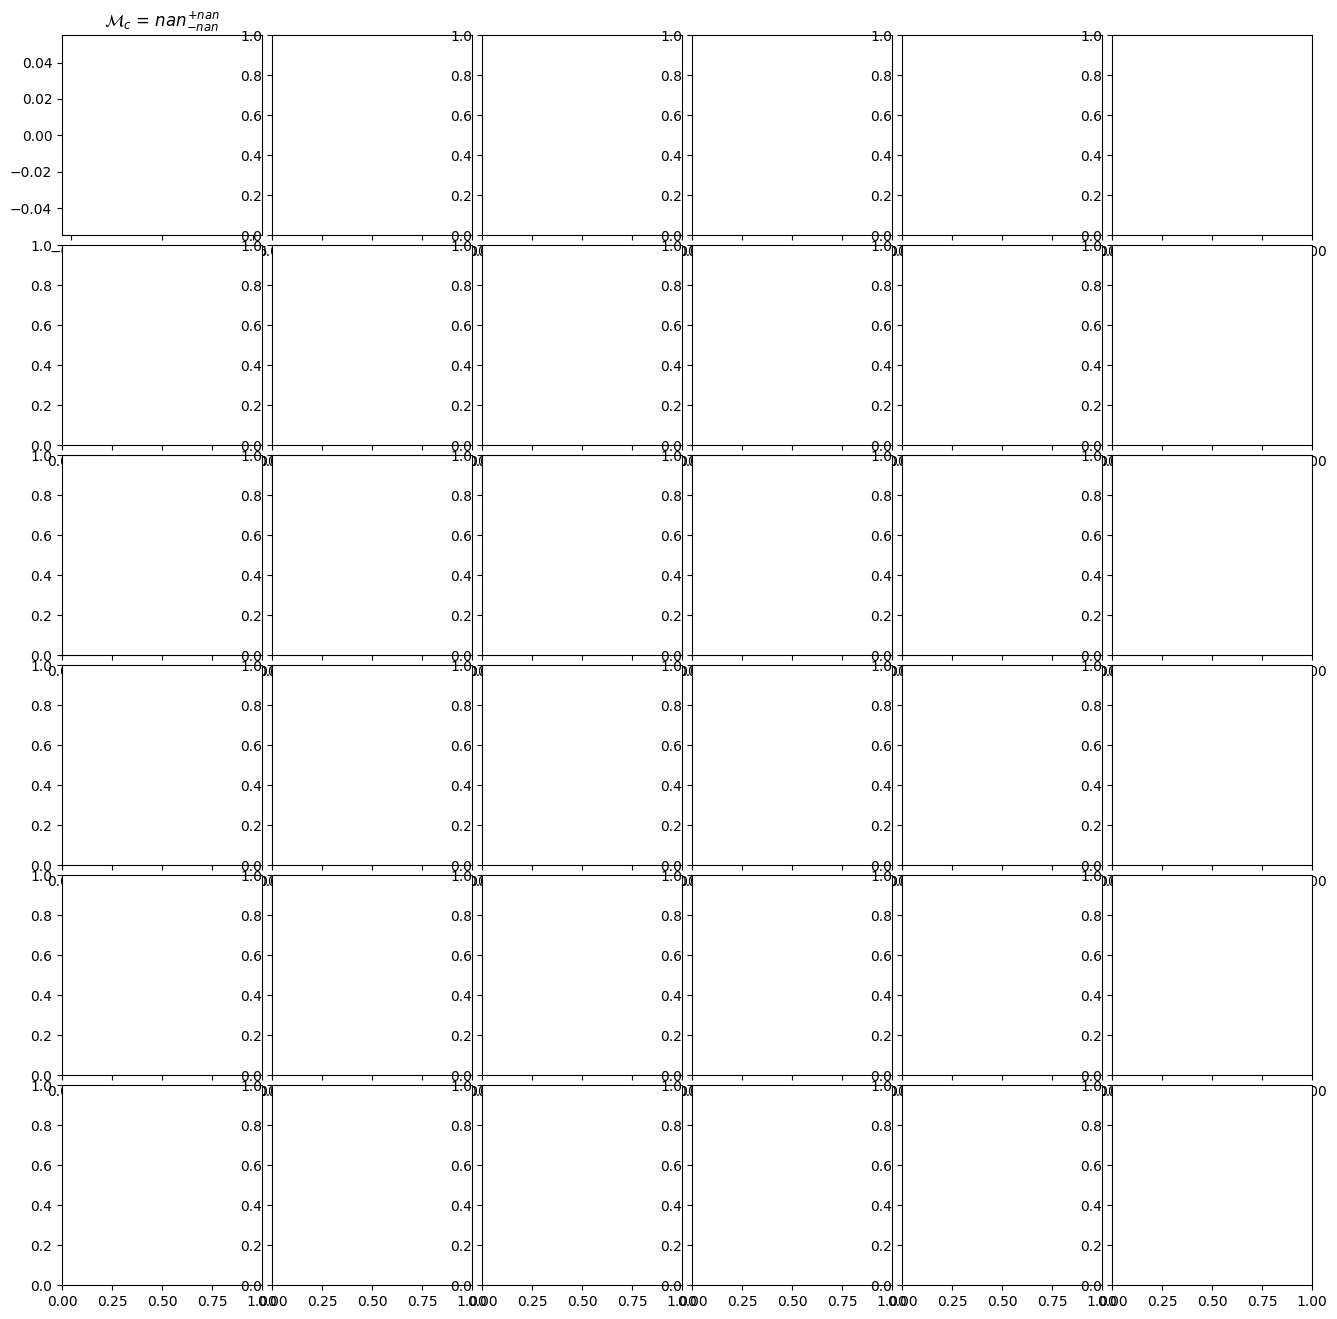

In [7]:
# ==========================================
# STEP 5: Extract results and visualise posteriors
# ==========================================
import pandas as pd
import corner
import matplotlib.pyplot as plt

# Sample from trained flow
sample_key = jax.random.key(123)
z_samples = trained_flow.sample(sample_key, sample_shape=(16384,))
phys_samples = np.array(target.samples_to_physical(z_samples))

# Build DataFrame with ripplegw parameter names
post = pd.DataFrame(phys_samples, columns=target.param_names)

# Derive component masses and mass ratio from Mc and eta
#   M_total = Mc / eta^(3/5),  m2 = (M - sqrt(M^2 - 4*M^2*eta))/2,  m1 = M - m2
Mc_s, eta_s = post['Mc'].values, post['eta'].values
M_total = Mc_s / eta_s**0.6
m2 = 0.5 * (M_total - np.sqrt(np.clip(M_total**2 * (1 - 4*eta_s), 0, None)))
m1 = M_total - m2
post['m1'] = m1
post['m2'] = m2
post['q'] = m2 / m1

# Print summary statistics (median and 90% credible interval)
print("=" * 60)
print("Posterior summary (median [5th, 95th percentile])")
print("=" * 60)
for col in ['Mc', 'eta', 'm1', 'm2', 'q', 'chi1', 'chi2', 'dist', 'tc', 'phic', 'iota']:
    lo, med, hi = np.percentile(post[col], [5, 50, 95])
    print(f"  {col:>6s} = {med:8.3f}  [{lo:8.3f}, {hi:8.3f}]")

print("\nPublished GW250114 values for comparison:")
print("  Mc_det ~ 30.3-31.6 Msun")
print("  m1     ~ 32.6-34.9 Msun")
print("  m2     ~ 30.6-33.2 Msun")
print("  q      > 0.91")

# Corner plot of key parameters
fig = corner.corner(
    post[['Mc', 'eta', 'dist', 'tc', 'chi1', 'chi2']].values,
    labels=[r'$\mathcal{M}_c$', r'$\eta$', r'$D_L$ [Mpc]', r'$t_c$ [s]', r'$\chi_1$', r'$\chi_2$'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    title_fmt='.2f',
)
fig.suptitle('GW250114 Flow Posterior', y=1.02)
plt.show()
